# Sentiment Analysis: Identifying Key Factors Influencing Course Evaluation Sentiments in Сoursera Reviews
*Andrei Baranov - IBU IT*

**Dataset and libraries imports**


In [283]:
import re
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/andrey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/andrey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [284]:
df_full = pd.read_csv('./dataset/reviews_by_course.csv')
# df_part = df_full.sample(n=1000, random_state=42)

df_full.head()
# df_part.head()

,CourseId,Review,Label
0,2-speed-it,BOring,1
1,2-speed-it,Bravo !,5
2,2-speed-it,Very goo,5
3,2-speed-it,"Great course - I recommend it for all, especia...",5
4,2-speed-it,One of the most useful course on IT Management!,5


### Now we should start clean our dataset and first of all lets remove unuseful data from the dataset

In [285]:
def remove_empty_reviews(dataframe, review_column):
    original_count = len(dataframe)
    cleaned_dataframe = dataframe.dropna(subset=[review_column])
    cleaned_dataframe = cleaned_dataframe[cleaned_dataframe[review_column].str.strip().astype(bool)]
    new_count = len(cleaned_dataframe)
    rows_removed = original_count - new_count
    return cleaned_dataframe, rows_removed  

df_full, rows_removed = remove_empty_reviews(df_full, 'Review')
print(f"Cleaned DataFrame:\n{df_full}\nNumer of removed rows: {rows_removed}")

Cleaned DataFrame:
          CourseId                                             Review  Label
0       2-speed-it                                             BOring      1
1       2-speed-it                                            Bravo !      5
2       2-speed-it                                           Very goo      5
3       2-speed-it  Great course - I recommend it for all, especia...      5
4       2-speed-it    One of the most useful course on IT Management!      5
...            ...                                                ...    ...
140315        zika  Trendy topic with talks from expertises in the...      4
140316        zika  Wonderful! Simple and clear language, good ins...      5
140317        zika   an interesting and fun course. thanks. dr quincy      5
140318        zika  very broad perspective, up to date information...      4
140319        zika  An informative course on the social and financ...      4

[140317 rows x 3 columns]
Numer of removed rows: 3


## Refining Category Patterns with Additional Keywords and Patterns

In this section, we will enhance the categorization of our dataset by refining category patterns using additional keywords and patterns. This step is essential for improving the accuracy of data classification and analysis.

## Identifying Categories

In [286]:
refined_category_patterns = {
    'Business': re.compile(r'business|marketing|finance|entrepreneurship|leadership|management', re.IGNORECASE),
    'Humanities and Arts': re.compile(r'history|art|music|philosophy|literature|culture', re.IGNORECASE),
    'Natural and Engineering Sciences': re.compile(r'engineering|biology|chemistry|physics|ecology|geology', re.IGNORECASE),
    'Health': re.compile(r'health|nutrition|medicine|wellness|clinical|public\shealth', re.IGNORECASE),
    'Language Learning': re.compile(r'language|english|spanish|chinese|linguistics', re.IGNORECASE),
    'Information Technology': re.compile(r'network|data|information\s?technology|it\s|cloud', re.IGNORECASE),
    'Computer Science': re.compile(r'python|computer|machine[-\s]?learning|data\s?science|programming|algorithm', re.IGNORECASE),
    'Personal Development': re.compile(r'self|personal|development|productivity|life\sskills', re.IGNORECASE),
    'Mathematics and Logic': re.compile(r'mathematics|math|logic|algebra|geometry|calculus', re.IGNORECASE),
    'Data Science': re.compile(r'data|analysis|big[-\s]?data|analytics|statistics', re.IGNORECASE),
    'Social Sciences': re.compile(r'sociology|psychology|politics|economics|anthropology', re.IGNORECASE),
    'Education': re.compile(r'learn|education|teaching|pedagogy|instructional', re.IGNORECASE),
    'Arts and Crafts': re.compile(r'craft|style|design|fashion|painting|sculpture', re.IGNORECASE)
}

# Function to categorize course based on CourseId using refined regex
def categorize_course_with_refined_regex(course_id):
    for category, pattern in refined_category_patterns.items():
        if pattern.search(course_id):
            return category
    return 'Other'

df_full['Category'] = df_full['CourseId'].apply(categorize_course_with_refined_regex)

In [287]:
unique_courses = set(df_full['CourseId'])
print(f"Total unique courses: {len(unique_courses)}")

other_count = df_full[df_full['Category'] == 'Other'].shape[0]
print(f"Total DF with Other Category: {other_count} and all DF {len(df_full)}")
print(f'Percent of Other category in DataFrame - {other_count/len(df_full)*100}')

# Grouping our data
grouped = df_full[df_full['Category'] == 'Other'].groupby('CourseId')

# Total Other Category we take is:
total_samples = 6000

n_samples_per_group = total_samples // len(grouped)

other_sample_uniform = pd.DataFrame()

for name, group in grouped:
    n_samples = min(n_samples_per_group, len(group))
    sampled_group = group.sample(n=n_samples, random_state=1)
    other_sample_uniform = pd.concat([other_sample_uniform, sampled_group], axis=0)

other_sample_uniform = other_sample_uniform.sample(n=min(6000, len(other_sample_uniform)), random_state=1)

# Dataframe without 'Other'
df_without_other = df_full[df_full['Category'] != 'Other']

df_final = pd.concat([df_without_other, other_sample_uniform])

print(f"Total number of reviews in the final dataset: {len(df_final)}")
other_count_final = df_final[df_final['Category'] == 'Other'].shape[0]
print(f"Number of 'Other' category in the final dataset: {other_count_final}")
print(f"Percent of 'Other' category in the final dataset: {other_count_final / len(df_final) * 100}%")

Total unique courses: 1835
Total DF with Other Category: 65014 and all DF 140317
Percent of Other category in DataFrame - 46.333658786889686
Total number of reviews in the final dataset: 80617
Number of 'Other' category in the final dataset: 5314
Percent of 'Other' category in the final dataset: 6.591661808303459%


* Because total df is 80.617 let's take only 5000 from the total number for better computation performance.
* 

In [288]:
df_part_5000 = df_final.sample(n=5000, random_state=40)
# df_full.head()
df_part_5000.head()

,CourseId,Review,Label,Category
10721,big-data-introduction,Some quiz have some bad wording which make it ...,4,Information Technology
9853,bayesian-statistics,Steep learning curve. really taxed my thinking...,4,Data Science
114381,python-databases,Very interesting.,5,Information Technology
78422,machine-learning,I'd love the assignments. They are really hand...,5,Computer Science
119941,responsive-web-design,Good!,5,Arts and Crafts


Counting the number of reviews in each course category

In [289]:
reviews_count_by_category = df_part_5000.groupby('Category')['Review'].count()

print(reviews_count_by_category)

Category
Arts and Crafts                      212
Business                             586
Computer Science                    1225
Data Science                         150
Education                            530
Health                               173
Humanities and Arts                  372
Information Technology               780
Language Learning                    178
Mathematics and Logic                111
Natural and Engineering Sciences      77
Other                                342
Personal Development                 183
Social Sciences                       81
Name: Review, dtype: int64


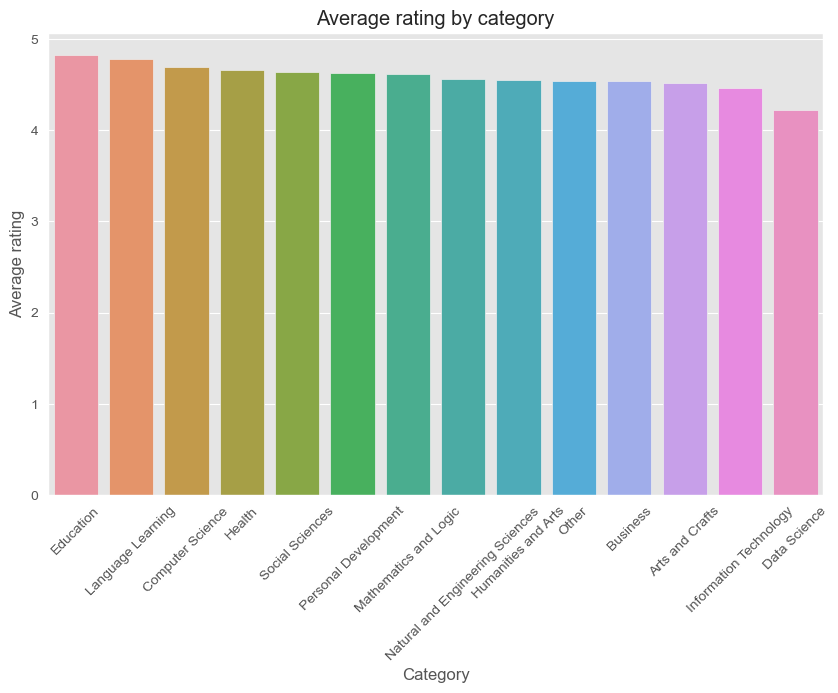

In [290]:
average_rating_by_category = df_part_5000.groupby('Category')['Label'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=average_rating_by_category.index, y=average_rating_by_category.values)
plt.xticks(rotation=45)
plt.title('Average rating by category')
plt.xlabel('Category')
plt.ylabel('Average rating')
plt.show()

In [291]:
def clean_review_modified(review):
    # Definition of stop words with exclusion of negations
    stopwords_modified = set(stopwords.words('english')) - {'no', 'not', 'never'}

    review = review.lower()
    
    tokens = word_tokenize(review)

    tokens = [word for word in tokens if word not in stopwords_modified]

    lemmatizer = WordNetLemmatizer()
    # Limited lemmatization
    tokens = [lemmatizer.lemmatize(word) if pos in ['N', 'V'] else word for word, pos in nltk.pos_tag(tokens)]

    return ' '.join(tokens)

df_final['Cleaned_Review'] = df_final["Review"].apply(clean_review_modified)
df_part_5000['Cleaned_Review'] = df_part_5000['Review'].apply(clean_review_modified)

df_part_5000.head()

,CourseId,Review,Label,Category,Cleaned_Review
10721,big-data-introduction,Some quiz have some bad wording which make it ...,4,Information Technology,quiz bad wording make hard understand .
9853,bayesian-statistics,Steep learning curve. really taxed my thinking...,4,Data Science,steep learning curve . really taxed thinking c...
114381,python-databases,Very interesting.,5,Information Technology,interesting .
78422,machine-learning,I'd love the assignments. They are really hand...,5,Computer Science,'d love assignments . really hand-ons .
119941,responsive-web-design,Good!,5,Arts and Crafts,good !


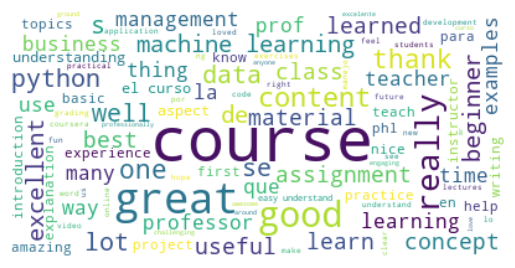

In [292]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_sampled_wordcloud(dataframe, review_column, sample_size=100):
    sampled_reviews = ' '.join(dataframe[review_column].sample(sample_size))
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(sampled_reviews)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
generate_sampled_wordcloud(df_part_5000, 'Cleaned_Review', 100)

In [293]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer(analyzer='word')
# learns the vocabulary unique and transforms to numerical format
train_features = vectorizer.fit_transform(df_final["Cleaned_Review"])
test_features = vectorizer.transform(df_part_5000["Cleaned_Review"])

print(train_features.shape)
print(test_features.shape)

word_freq = np.sum(train_features, axis=0)
word_freq = np.array(word_freq).flatten()

vocab = vectorizer.get_feature_names_out()
freq_dict = dict(zip(vocab, word_freq))

sorted_freq = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
for word, freq in sorted_freq[:10]:
    print(f"{word}: {freq}")

(80617, 43393)
(5000, 43393)
course: 52492
great: 16416
good: 14001
learning: 8854
really: 8646
not: 8546
excellent: 7511
well: 6713
lot: 6096
learn: 6061


In [294]:
import spacy
nlp = spacy.load('en_core_web_sm')

def extract_aspects_with_dependency_parsing(text):
    doc = nlp(text)
    aspects = []
    for token in doc:
        if token.pos_ == 'NOUN':
            aspect_found = False
            for child in token.children:
                # adjectival modifiers or adjectival complements
                if child.dep_ in ['amod', 'acomp']:
                    # Vader's polarity_scores
                    sentiment = sia.polarity_scores(child.text)['compound']
                    sentiment_label = 'positive' if sentiment > 0 else 'negative' if sentiment < 0 else 'neutral'
                    aspects.append((token.text, sentiment_label))
                    aspect_found = True
            if not aspect_found:
                sentiment = sia.polarity_scores(text)['compound']
                sentiment_label = 'positive' if sentiment > 0 else 'negative' if sentiment < 0 else 'neutral'
                aspects.append((token.text, sentiment_label))
    return aspects

df_part_5000['Aspects_and_Sentiments'] = df_part_5000["Cleaned_Review"].apply(extract_aspects_with_dependency_parsing)

df_output = df_part_5000[['Cleaned_Review', 'Label', 'Aspects_and_Sentiments']]
df_output

,Cleaned_Review,Label,Aspects_and_Sentiments
10721,quiz bad wording make hard understand .,4,"[(wording, negative)]"
9853,steep learning curve . really taxed thinking c...,4,"[(learning, positive), (curve, neutral), (thin..."
114381,interesting .,5,[]
78422,'d love assignments . really hand-ons .,5,"[(assignments, positive), (hand, positive), (o..."
119941,good !,5,[]
...,...,...,...
57070,brilliant lecture ever . glad learner lesson .,5,"[(lecture, positive), (learner, positive), (le..."
114755,", another excellent course dr. chuck . however...",4,"[(course, positive), (coursera, positive), (fo..."
67675,great course lot tips explanations learn improve,5,"[(course, positive), (lot, positive), (tips, p..."
104525,amazing intro programming class . 'm consultin...,5,"[(intro, positive), (programming, positive), (..."


In [295]:
word_freq_dict = {word: freq for word, freq in zip(vocab, word_freq)}
threshold = 5
def filter_aspects_in_review(aspects, word_freq_dict, threshold):
    return [aspect for aspect in aspects if word_freq_dict.get(aspect[0], 0) > threshold]

df_part_5000['Filtered_Aspects_and_Sentiments'] = df_part_5000['Aspects_and_Sentiments'].apply(lambda aspects: filter_aspects_in_review(aspects, word_freq_dict, threshold))

df_output_filtered = df_part_5000[['Cleaned_Review', 'Label', 'Filtered_Aspects_and_Sentiments']]
print(df_output_filtered.head())

                                           Cleaned_Review  Label  \
10721             quiz bad wording make hard understand .      4   
9853    steep learning curve . really taxed thinking c...      4   
114381                                      interesting .      5   
78422             'd love assignments . really hand-ons .      5   
119941                                             good !      5   

                          Filtered_Aspects_and_Sentiments  
10721                               [(wording, negative)]  
9853    [(learning, positive), (curve, neutral), (thin...  
114381                                                 []  
78422   [(assignments, positive), (hand, positive), (o...  
119941                                                 []  


In [296]:
def count_aspect_sentiments(aspects):
    positive, negative, neutral = 0, 0, 0
    for aspect in aspects:
        if aspect[1] == 'positive':
            positive += 1
        elif aspect[1] == 'negative':
            negative += 1
        else:
            neutral += 1
    return positive, negative, neutral

df_part_5000['Positive_Aspects'], df_part_5000['Negative_Aspects'], df_part_5000['Neutral_Aspects'] = zip(*df_part_5000['Filtered_Aspects_and_Sentiments'].apply(count_aspect_sentiments))
df_part_5000.head()

,CourseId,Review,Label,Category,Cleaned_Review,Aspects_and_Sentiments,Filtered_Aspects_and_Sentiments,Positive_Aspects,Negative_Aspects,Neutral_Aspects
10721,big-data-introduction,Some quiz have some bad wording which make it ...,4,Information Technology,quiz bad wording make hard understand .,"[(wording, negative)]","[(wording, negative)]",0,1,0
9853,bayesian-statistics,Steep learning curve. really taxed my thinking...,4,Data Science,steep learning curve . really taxed thinking c...,"[(learning, positive), (curve, neutral), (thin...","[(learning, positive), (curve, neutral), (thin...",2,0,2
114381,python-databases,Very interesting.,5,Information Technology,interesting .,[],[],0,0,0
78422,machine-learning,I'd love the assignments. They are really hand...,5,Computer Science,'d love assignments . really hand-ons .,"[(assignments, positive), (hand, positive), (o...","[(assignments, positive), (hand, positive), (o...",3,0,0
119941,responsive-web-design,Good!,5,Arts and Crafts,good !,[],[],0,0,0


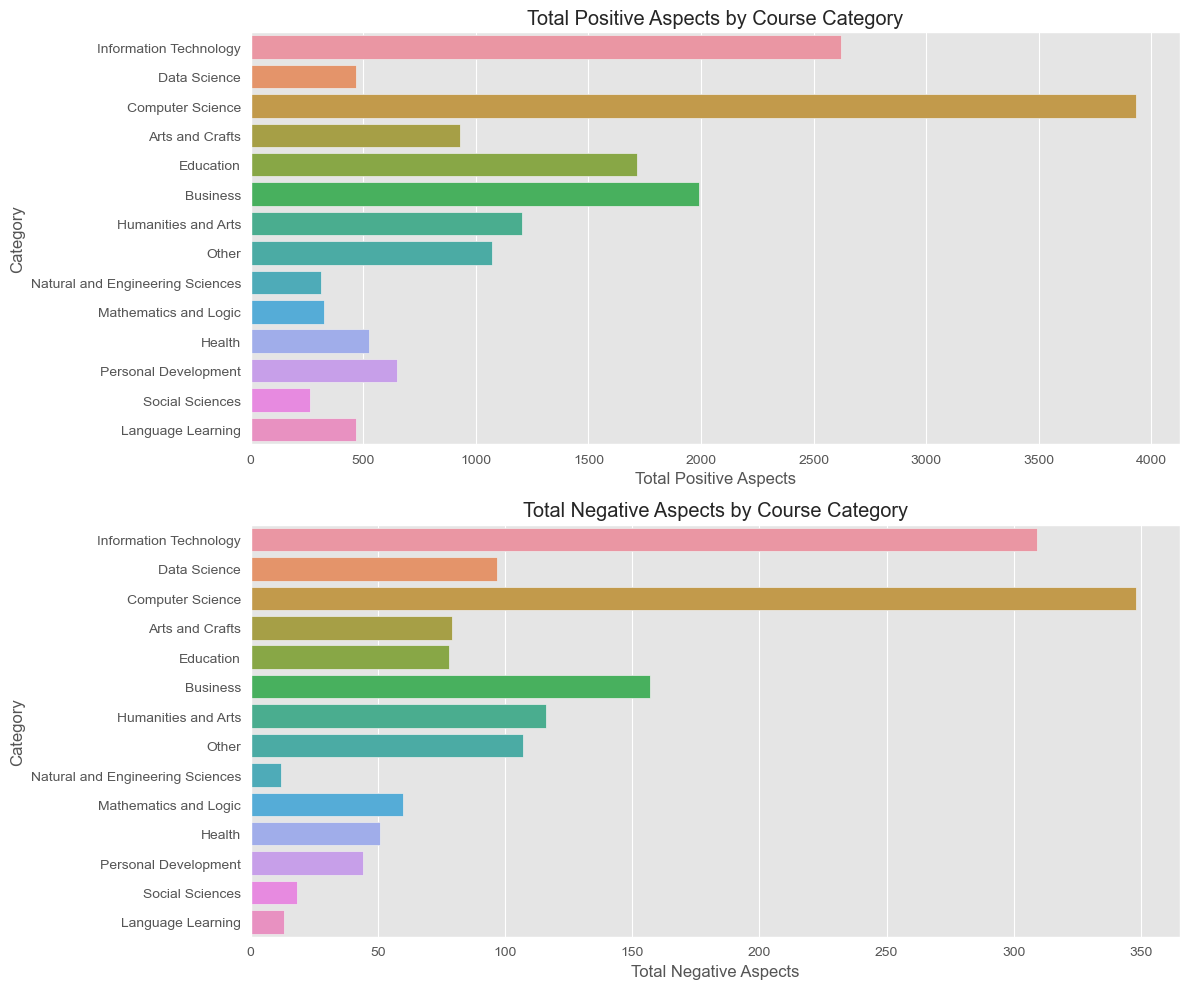

In [297]:
def extract_aspects_sentiments(df):
    categories = df['Category'].unique()

    result = []

    for category in categories:
        category_df = df[df['Category'] == category]
        positive_aspects = category_df['Positive_Aspects'].sum()
        negative_aspects = category_df['Negative_Aspects'].sum()

        result.append({
            'Category': category,
            'Positive_Aspect': positive_aspects,
            'Negative_Aspect': negative_aspects
        })

    return result

aspects_sentiments = extract_aspects_sentiments(df_part_5000)

aspects_df = pd.DataFrame(aspects_sentiments)

plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plotting positive aspects
sns.barplot(x='Positive_Aspect', y='Category', data=aspects_df, ax=axes[0])
axes[0].set_title('Total Positive Aspects by Course Category')
axes[0].set_xlabel('Total Positive Aspects')
axes[0].set_ylabel('Category')

# Plotting negative aspects
sns.barplot(x='Negative_Aspect', y='Category', data=aspects_df, ax=axes[1])
axes[1].set_title('Total Negative Aspects by Course Category')
axes[1].set_xlabel('Total Negative Aspects')
axes[1].set_ylabel('Category')

plt.tight_layout()
plt.show()

In [298]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def calculate_overall_sentiment(review):
    sentiment_score = sia.polarity_scores(review)
    return sentiment_score['compound']

df_part_5000['Overall_Sentiment'] = df_part_5000['Review'].apply(calculate_overall_sentiment)

df_part_5000['Review_Length'] = df_part_5000['Review'].apply(len)

X = df_part_5000[['Overall_Sentiment', 'Review_Length', 'Positive_Aspects', 'Negative_Aspects', 'Neutral_Aspects']]
y = df_part_5000['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.746


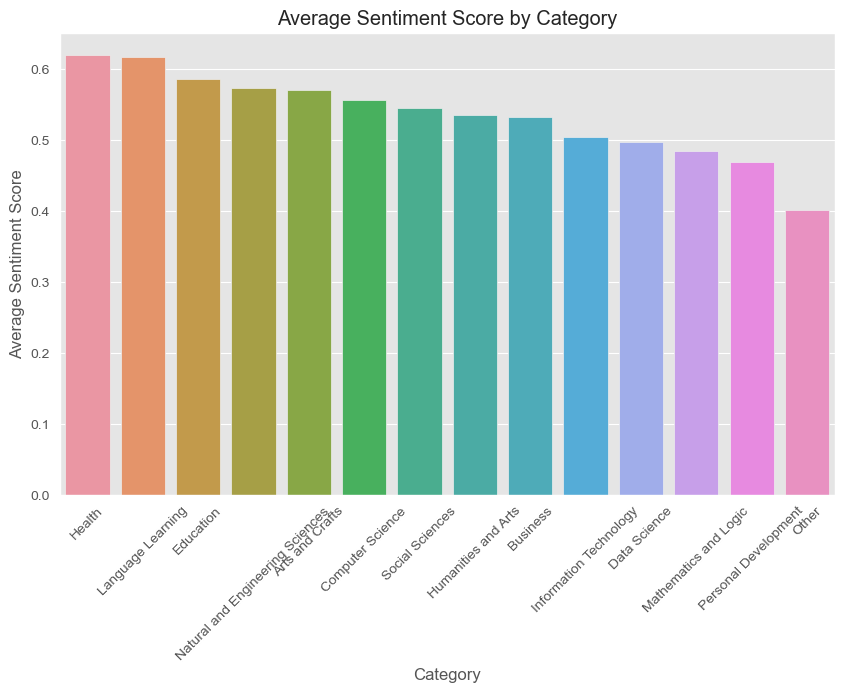

In [299]:
average_sentiment_by_category = df_part_5000.groupby('Category')['Overall_Sentiment'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=average_sentiment_by_category.index, y=average_sentiment_by_category.values)
plt.xticks(rotation=45)
plt.title('Average Sentiment Score by Category')
plt.xlabel('Category')
plt.ylabel('Average Sentiment Score')
plt.show()

In [300]:
def predict_review_rating(review, my_rating_param):
    overall_sentiment = calculate_overall_sentiment(review)
    # determining its rating
    review_length = len(review)
    aspects = extract_aspects_with_dependency_parsing(review)
    positive, negative, neutral = count_aspect_sentiments(aspects)

    features = pd.DataFrame([[overall_sentiment, review_length, positive, negative, neutral]], columns=['Overall_Sentiment', 'Review_Length', 'Positive_Aspects', 'Negative_Aspects', 'Neutral_Aspects'])

    predicted_rating = model.predict(features)[0]

    print(f"Predicted score: {predicted_rating}")
    print(f"Your score: {my_rating_param}")

    print("Aspects that influenced the rating:")
    for aspect in aspects:
        print(f"{aspect[0]}: {aspect[1]}")

    if predicted_rating == my_rating_param:
        print("Scores are the same!")
    else:
        print("Scores are different.")

new_review = "I thought the instructor paced herself well and was very articulate. I would recommend this course."

new_review_1 = "The course was okay, nothing exceptional, but not terrible either. The instructor's teaching style was average, and the content was somewhat interesting. It's neither a top recommendation nor a complete waste of time."

new_review_2 = "The course content was quite outdated, and the instructor seemed disorganized at times. I expected more from this course, but it fell short of my expectations."

my_rating = 4
predict_review_rating(new_review, my_rating)

Predicted score: 5
Your score: 4
Aspects that influenced the rating:
instructor: positive
course: positive
Scores are different.
